<a href="https://colab.research.google.com/github/marwan-hamzawy/Credit-Card-Approval-PredictionML/blob/main/Final_FinalCopy_of_V2_Project1_Marwan_Ahmed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [133]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from matplotlib import gridspec
import itertools
from imblearn.over_sampling import SMOTE
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Data Preprocessing

In [134]:
df_credit = pd.read_csv('/content/drive/MyDrive/Dataset/credit_record.csv')
df_credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [135]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [136]:
df_credit['STATUS'].unique()

array(['X', '0', 'C', '1', '2', '3', '4', '5'], dtype=object)

In [137]:
df_credit['STATUS'].value_counts()

,count
STATUS,
C,442031
0,383120
X,209230
1,11090
5,1693
2,868
3,320
4,223


In [138]:
df_credit['ID'].duplicated().sum()


1002590

In [139]:
df_credit.isnull().sum()

,0
ID,0
MONTHS_BALANCE,0
STATUS,0


In [140]:
df_application_data = pd.read_csv('/content/drive/MyDrive/Dataset/application_record.csv')
df_application_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [141]:
df_application_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [142]:
df_application_data['ID'].duplicated().sum()

47

In [143]:
df_application_data.isnull().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


## Good & Bad Cretria
### Custom Mode Calculation and Data Merging

This code in photo 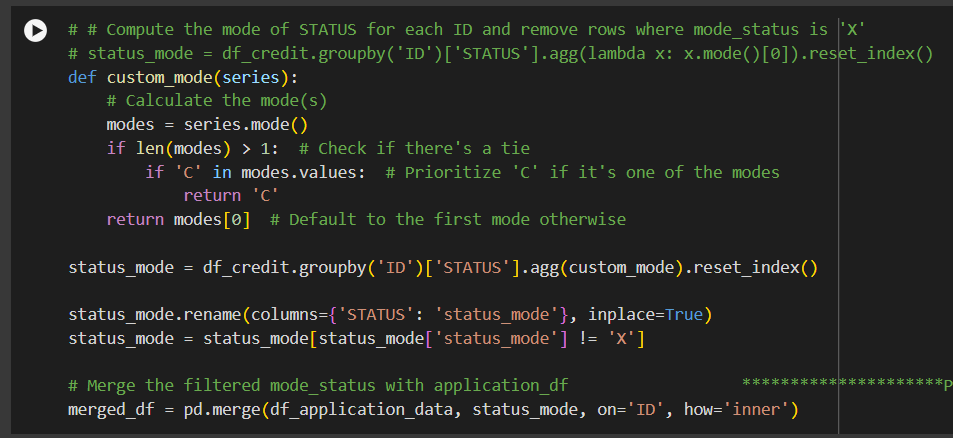calculates the most frequent `STATUS` for each `ID` in the `df_credit` DataFrame. The `custom_mode` function returns the mode of `STATUS` values, prioritizing `'C'` if there is a tie. If `'C'` isn't part of the tie, it returns the first mode.

**Example**:  
For `ID=123`, if `STATUS = ['C', 'C', '1', '0']`, the mode is `'C'`. For `STATUS = ['1', '1', '0', '0']`, the mode is `'1'`.

The resulting `status_mode` DataFrame is filtered to exclude `'X'` values, then merged with `df_application_data` based on `ID`, keeping only matching rows.

This ensures that each `ID` in the merged DataFrame has the most frequent `STATUS`, excluding `'X'` values.
## *But Using just the mode (most frequent value) ignores the broader distribution of statuses and loses temporal patterns (e.g., improving or worsening payment behavior).*

### So,
We made the running logic

This code analyzes credit behavior to label applicants as **"good"** or **"bad"** based on their payment history.

1. **Status Counts**: Creates a summary of `STATUS` counts per `ID`, calculates total records, `bad_ratio` (proportion of bad statuses: `0-5`), and `paid_ratio` (proportion of `C` statuses).  
   **Example**: For `ID=123` with `STATUS=['C', '1', '0']`, `bad_ratio = 2/3` and `paid_ratio = 1/3`.

2. **Recency Analysis**: Counts bad statuses (`0-5`) in the last 6 months for each `ID`.

3. **Merging**: Combines the credit data with application data.

4. **Labeling**: Classifies applicants as "bad" if `bad_ratio > 0.861` or recent bad statuses exist; otherwise, labels them "good".  
   **Example**: If `bad_ratio = 0.9` or recent bad count = 1, `status_label = "bad"`.

In [144]:
status_counts = df_credit.pivot_table(index='ID', columns='STATUS', aggfunc='size', fill_value=0)

#Normalize column names for clarity
status_counts.columns = [f'status_{col}' for col in status_counts.columns]

#Calculate ratios
status_counts['total_records'] = status_counts.sum(axis=1)
status_counts['bad_ratio'] = status_counts[['status_0', 'status_1', 'status_2',
                                            'status_3', 'status_4', 'status_5']].sum(axis=1) / status_counts['total_records']
status_counts['paid_ratio'] = status_counts['status_C'] / status_counts['total_records']

#Recency analysis (last 6 months)
recent_data = df_credit[df_credit['MONTHS_BALANCE'] >= -6]  # Last 6 months
recent_bad_count = recent_data.groupby('ID')['STATUS'].apply(lambda x: (x.isin(['0', '1', '2', '3', '4', '5'])).sum())
status_counts['recent_bad_count'] = recent_bad_count

#Merge with application data
merged_df = pd.merge(df_application_data, status_counts, on='ID', how='inner')

#Define labels (good/bad based on bad_ratio threshold)
def label_status(row):
    if row['bad_ratio'] > 0.34 or row['recent_bad_count'] > 0:
        return 'bad'
    else:
        return 'good'

merged_df['status_label'] = merged_df.apply(label_status, axis=1)


In [145]:
merged_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,status_3,status_4,status_5,status_C,status_X,total_records,bad_ratio,paid_ratio,recent_bad_count,status_label
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,0,13,1,16,0.125000,0.812500,0.0,good
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,0,12,1,15,0.133333,0.800000,0.0,good
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,7,16,30,0.233333,0.233333,0.0,good
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,0,0,0,3,5,0.400000,0.000000,2.0,bad
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,0,0,0,5,5,0.000000,0.000000,NaN,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,1,3,0,8,12,0.333333,0.000000,4.0,bad
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,1,1,7,5,0,24,0.791667,0.208333,2.0,bad
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,1,7,14,0,33,0.575758,0.424242,0.0,bad
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,10,1.000000,0.000000,7.0,bad


In [146]:
merged_df['status_label'].value_counts()

,count
status_label,
bad,21948
good,14509


## Visualization

<ipython-input-147-86a582dff101>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x='status_label', palette='Set2')


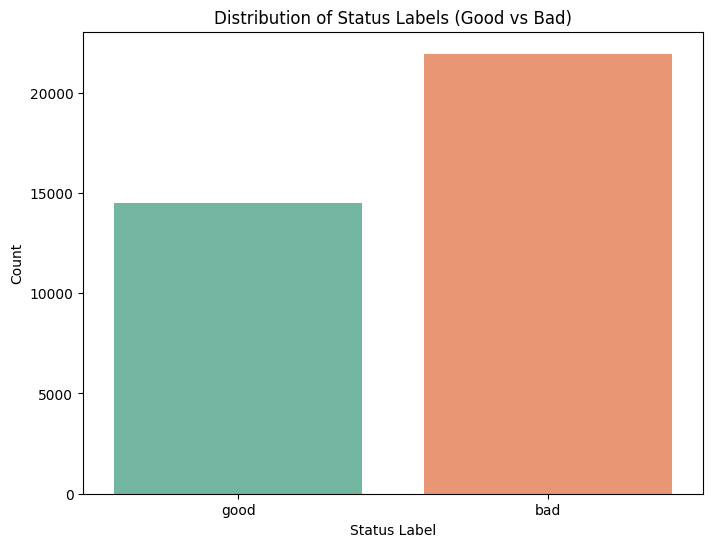

In [147]:
#Visualize the distribution of status labels
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_df, x='status_label', palette='Set2')
plt.title('Distribution of Status Labels (Good vs Bad)')
plt.xlabel('Status Label')
plt.ylabel('Count')
plt.show()


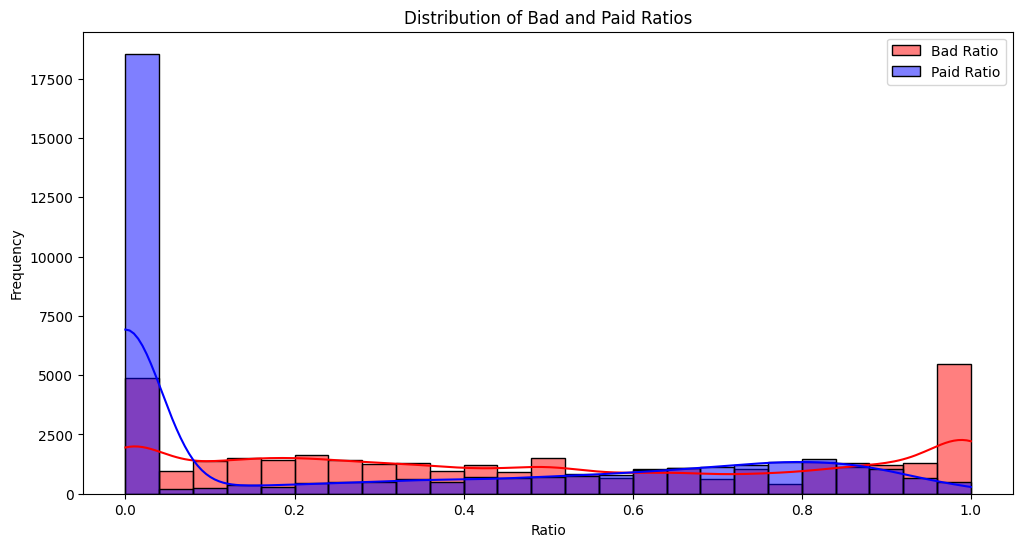

In [148]:
# Step 1: Visualize the bad_ratio and paid_ratio distribution
plt.figure(figsize=(12, 6))

# Plot bad_ratio and paid_ratio
sns.histplot(merged_df['bad_ratio'], kde=True, color='red', label='Bad Ratio')
sns.histplot(merged_df['paid_ratio'], kde=True, color='blue', label='Paid Ratio')

plt.title('Distribution of Bad and Paid Ratios')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.show()

<ipython-input-149-041005389dfa>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='status_label', y='bad_ratio', palette='Set2')
<ipython-input-149-041005389dfa>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='status_label', y='paid_ratio', palette='Set2')


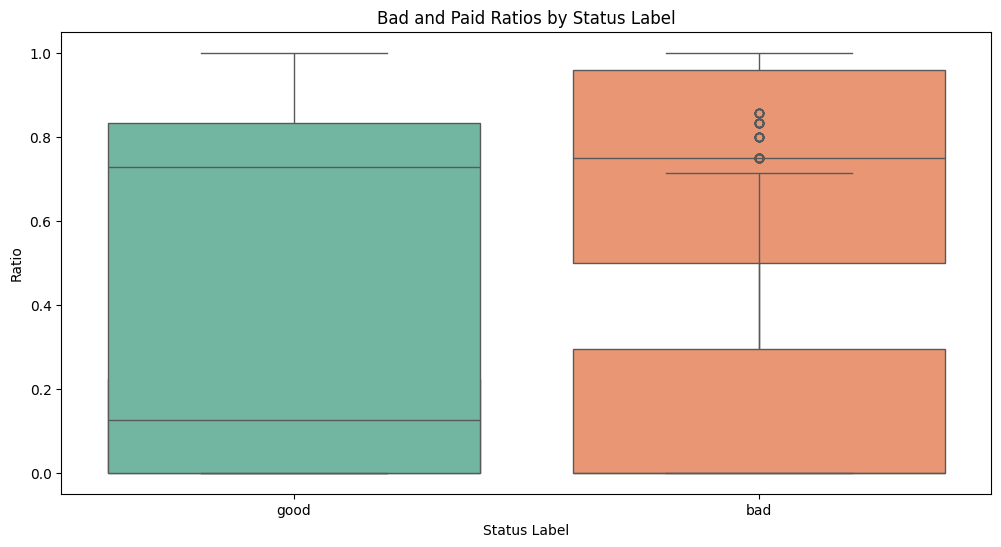

In [149]:
#Visualize bad_ratio and paid_ratio by status_label
plt.figure(figsize=(12, 6))

# Create a boxplot to show the distribution of bad_ratio and paid_ratio for good/bad labels
sns.boxplot(data=merged_df, x='status_label', y='bad_ratio', palette='Set2')
sns.boxplot(data=merged_df, x='status_label', y='paid_ratio', palette='Set2')

plt.title('Bad and Paid Ratios by Status Label')
plt.xlabel('Status Label')
plt.ylabel('Ratio')
plt.show()


## Preprocessing & Apply RandForst

## Label Encoding


**What is Label Encoding?**  
Label Encoding is a preprocessing technique used in machine learning to convert text-based (categorical) data into numerical values. Since most machine learning algorithms require numerical input, this step ensures that categorical features can be used in model training. Each unique category is assigned a specific numeric value.

**Example**:  
Suppose a dataset has a `Height` column with values like `Tall`, `Medium`, and `Short`. After applying label encoding, the column is transformed as follows:  
- `Tall → 0`  
- `Medium → 1`  
- `Short → 2`  

This allows the model to process the `Height` column as numerical data without changing the original relationships between categories.

**Limitation**:  
While label encoding is simple and effective, it can lead to unintended issues in models that assume numerical order or priority. For instance, the encoding (`Tall=0`, `Medium=1`, `Short=2`) might imply that `Short` is greater than `Tall`, which is incorrect if the categories are unordered. In such cases, more advanced encoding methods like one-hot encoding might be preferable.

##**My Previous Trial**
I tried to write One-Hot code for the categorical columns makeing the different elements in the column as a separate feature but eventually the No. of features has icreased up to 51 which lead to more complexity and more computations while training the models.


In [150]:
#Handle Missing Values
merged_df.fillna('Unknown', inplace=True)  # Replace NaNs with 'Unknown'

#Encode Categorical Variables
from sklearn.preprocessing import LabelEncoder

# Encode the 'status_label' (target variable)
label_encoder = LabelEncoder()
merged_df['status_label'] = label_encoder.fit_transform(merged_df['status_label'])  # "bad" -> 1, "good" -> 0

# Convert all columns with mixed types (int + str) to strings before encoding
categorical_cols = merged_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    merged_df[col] = merged_df[col].astype(str)  # Convert all values in categorical columns to strings

# Encode other categorical columns in df_application_data (if any)
for col in categorical_cols:
    merged_df[col] = label_encoder.fit_transform(merged_df[col])  # Apply label encoding


<ipython-input-150-a0aa90dd6a71>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna('Unknown', inplace=True)  # Replace NaNs with 'Unknown'


In [151]:
merged_df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'status_0',
       'status_1', 'status_2', 'status_3', 'status_4', 'status_5', 'status_C',
       'status_X', 'total_records', 'bad_ratio', 'paid_ratio',
       'recent_bad_count', 'status_label'],
      dtype='object')

In [152]:
#Split Features and Target
X = merged_df.drop(columns=['ID', 'status_label',])

y = merged_df['status_label']

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train Random Forest Model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf_model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Random Forest Model: {accuracy * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Accuracy Random Forest Model: 99.99%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6495
           1       1.00      1.00      1.00      4443

    accuracy                           1.00     10938
   macro avg       1.00      1.00      1.00     10938
weighted avg       1.00      1.00      1.00     10938


Confusion Matrix:
[[6494    1]
 [   0 4443]]


## Logistic Regression

In [153]:
#Train Logistic Regression Model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr_model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Logistic Regression Accuracy: 97.05%

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6495
           1       0.96      0.96      0.96      4443

    accuracy                           0.97     10938
   macro avg       0.97      0.97      0.97     10938
weighted avg       0.97      0.97      0.97     10938


Logistic Regression Confusion Matrix:
[[6332  163]
 [ 160 4283]]


## SVM

In [154]:
#Train Support Vector Machine (SVM) Model
svm_model = SVC(random_state=42, kernel='rbf')  # Linear Kernel for SVM
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = svm_model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy * 100:.2f}%")

# Classification Report
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


SVM Accuracy: 97.78%

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6495
           1       0.97      0.98      0.97      4443

    accuracy                           0.98     10938
   macro avg       0.98      0.98      0.98     10938
weighted avg       0.98      0.98      0.98     10938


SVM Confusion Matrix:
[[6358  137]
 [ 106 4337]]


## Cross Validation

In [159]:
cross_val_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)
print("Random Forest Cross-Validation Scores:", cross_val_scores)
print("Mean Cross-Validation Score:", cross_val_scores.mean())

Random Forest Cross-Validation Scores: [0.99980408 0.99980408 0.99980408 0.99960815 1.        ]
Mean Cross-Validation Score: 0.9998040752351096


In [160]:
cross_val_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)
print("Logistic Regression Cross-Validation Scores:", cross_val_scores)
print("Mean Cross-Validation Score:", cross_val_scores.mean())

Logistic Regression Cross-Validation Scores: [0.97080721 0.97002351 0.97139498 0.96884796 0.96982167]
Mean Cross-Validation Score: 0.9701790682473952


In [161]:
cross_val_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5)
print("SVM Cross-Validation Scores:", cross_val_scores)
print("Mean Cross-Validation Score:", cross_val_scores.mean())

SVM Cross-Validation Scores: [0.97276646 0.97452978 0.97394201 0.97590125 0.97530864]
Mean Cross-Validation Score: 0.9744896280815821


## Grid Search & Hyperparameter Tuneing

In [162]:
clf = GridSearchCV(lr_model, {'C': [1, 10, 100, 1000]}, cv=5, return_train_score=False)
clf.fit(X_train_scaled, y_train)
clf.cv_results_

{'mean_fit_time': array([0.11068459, 0.12939758, 0.13201008, 0.14555402]),
 'std_fit_time': array([0.0231259 , 0.00705188, 0.01014008, 0.02000153]),
 'mean_score_time': array([0.00416064, 0.00465665, 0.00402226, 0.00343432]),
 'std_score_time': array([0.00115401, 0.00133002, 0.00122323, 0.00054702]),
 'param_C': masked_array(data=[1, 10, 100, 1000],
              mask=[False, False, False, False],
        fill_value=999999),
 'params': [{'C': 1}, {'C': 10}, {'C': 100}, {'C': 1000}],
 'split0_test_score': array([0.97080721, 0.97080721, 0.97080721, 0.97080721]),
 'split1_test_score': array([0.97002351, 0.96982759, 0.96982759, 0.96982759]),
 'split2_test_score': array([0.97139498, 0.97080721, 0.97080721, 0.97080721]),
 'split3_test_score': array([0.96884796, 0.96884796, 0.96884796, 0.96884796]),
 'split4_test_score': array([0.96982167, 0.96982167, 0.96982167, 0.96982167]),
 'mean_test_score': array([0.97017907, 0.97002233, 0.97002233, 0.97002233]),
 'std_test_score': array([0.00087141, 0.

In [163]:
df = pd.DataFrame(clf.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.110685,0.023126,0.004161,0.001154,1,{'C': 1},0.970807,0.970024,0.971395,0.968848,0.969822,0.970179,0.000871,1
1,0.129398,0.007052,0.004657,0.001330,10,{'C': 10},0.970807,0.969828,0.970807,0.968848,0.969822,0.970022,0.000733,2
2,0.132010,0.010140,0.004022,0.001223,100,{'C': 100},0.970807,0.969828,0.970807,0.968848,0.969822,0.970022,0.000733,2
3,0.145554,0.020002,0.003434,0.000547,1000,{'C': 1000},0.970807,0.969828,0.970807,0.968848,0.969822,0.970022,0.000733,2


In [164]:
df[['param_C', 'mean_test_score']]

,param_C,mean_test_score
0,1,0.970179
1,10,0.970022
2,100,0.970022
3,1000,0.970022


In [165]:
# Define the Logistic Regression model
model_logistic = LogisticRegression(max_iter=1000)

# Define a reduced grid of hyperparameters
param_grid_logistic = {
    'C': [0.1, 1],  # Regularization strength (smaller range to reduce combinations)
    'penalty': ['l2'],  # Use only L2 regularization for simplicity
    'solver': ['lbfgs']  # lbfgs is efficient for L2 penalty with medium-sized datasets
}

# Set up Grid Search with Cross-Validation
grid_search_logistic = GridSearchCV(model_logistic, param_grid_logistic, cv=3, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search_logistic.fit(X_train_scaled, y_train)

# Output results
print("Best Parameters for Logistic Regression:", grid_search_logistic.best_params_)
print("Best Score for Logistic Regression:", grid_search_logistic.best_score_)

Best Parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score for Logistic Regression: 0.9706101335356684


In [166]:
# Define the Random Forest model
model_rf = RandomForestClassifier()

# Define a reduced grid of hyperparameters
param_grid_rf = {
    'n_estimators': [50, 100],  # Fewer trees for faster computation
    'max_depth': [10, 20],  # Smaller depths to speed up training
    'min_samples_split': [2, 5],  # Keep split thresholds small for simplicity
    'min_samples_leaf': [1],  # Focus on a single value for simplicity
    'criterion': ['gini']  # Use only 'gini' for efficiency
}

# Set up Grid Search with Cross-Validation
grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=3, scoring='accuracy')

# Fit the GridSearchCV to the data
grid_search_rf.fit(X_train_scaled, y_train)

# Output results
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Score for Random Forest:", grid_search_rf.best_score_)

Best Parameters for Random Forest: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score for Random Forest: 0.9998432479034407


In [167]:
model_params = {
                'svm': {'model': SVC(gamma = 'auto'),
                        'params': {
                            'C': [ 10, 20, 100, 150, 200],
                            'kernel': ['rbf']
                        }
               },

               'random_forest': {'model': RandomForestClassifier(),
                                'params': {
                                    'n_estimators': [ 10, 50, 100, 150, 200, 250],
                                }
               },
               'logistic_regression': {'model': LogisticRegression(max_iter=1000),
                                       'params': {
                                           'C': [ 10, 100, 150, 200, 250]
                                       }
               }
}

In [168]:
scores =[]

for model_name, mp in model_params.items():
  clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
  clf.fit(X_train_scaled, y_train)
  scores.append({
      'model': model_name,
      'best_score': clf.best_score_,
      'best_params': clf.best_params_
  })

In [169]:
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df

,model,best_score,best_params
0,svm,0.981935,"{'C': 200, 'kernel': 'rbf'}"
1,random_forest,0.999922,{'n_estimators': 150}
2,logistic_regression,0.970022,{'C': 10}


**Model Evaluation**:  
- **Model 1** (Random Forest, 99.99% accuracy) delivers nearly perfect metrics with an almost flawless confusion matrix. However, such results strongly suggest overfitting, as the model might be memorizing the data rather than generalizing effectively.  
- **Model 2** (Logistic Regression, 97.05% accuracy) demonstrates good performance, particularly in recall and precision for both classes. However, the confusion matrix shows some misclassifications, particularly in predicting class `0`.  
- **Model 3** (SVM, 97.78% accuracy) provides a strong balance between accuracy and generalization. The classification report indicates robust precision, recall, and f1-scores for both classes, with fewer misclassifications than Logistic Regression and better generalization than Random Forest.  

**Best Model**:  
The **SVM model** is the best choice for this task due to its strong accuracy and generalization ability. While Random Forest might overfit the data and Logistic Regression has relatively more misclassifications, SVM strikes an ideal balance, making it more reliable for real-world scenarios.